<pre><h1>Introduction:</h1>
The Travel Insurance dataset contains information about customers and whether they purchased insurance. The goal is to use this data to predict whether future customers will be interested in purchasing insurance.

In this project, we begin with Exploratory Data Analysis (EDA) before building machine learning models. Models such as K-Nearest Neighbors (KNN), Decision Trees, Random Forest, and Support Vector Machines (SVM) are used for predictions. The results are then evaluated to determine the best-performing model.

<h4><b>Business Objective:</b></h4>
Let’s illustrate this with a simple example: If a customer is interested in purchasing travel insurance, but the model incorrectly predicts that they are not interested, the company may lose a potential sale. Therefore, the main business objective is to minimize Type II errors (False Negatives). The best model will be the one that achieves the highest recall score, as it reduces the chances of missing potential buyers.

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.proportion import proportion_confint
from utils import build_and_tune_model, plot_decorator

warnings.filterwarnings(action="ignore")

<pre><h1>1. Data Loading and Observations</h1>

In [2]:
# Download the dataset from kaggle into the local machine
# dataset = r"https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data"
# od.download(dataset, force=True)

In [3]:
# list the files to find the names of the files
# data_dir = r".\travel-insurance-prediction-data"
# os.listdir(data_dir)

In [4]:
data = pd.read_csv(r"TravelInsurancePrediction.csv")
data.head(2)

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0


In [5]:
data.drop(["Unnamed: 0"], axis=1, inplace=True)

In [6]:
data.duplicated().sum()

738

<h4><b>Action:</b></h4>
<pre>The duplicates are being removed to avoid the bias while fiting the model. Keeping the duplicates can lead data leakage, where the model sees the same information in both training and testing. This can artificially inflate performance metrics, making the model seem more accurate than it actually is.

In [7]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1249 entries, 0 to 1985
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1249 non-null   int64 
 1   Employment Type      1249 non-null   object
 2   GraduateOrNot        1249 non-null   object
 3   AnnualIncome         1249 non-null   int64 
 4   FamilyMembers        1249 non-null   int64 
 5   ChronicDiseases      1249 non-null   int64 
 6   FrequentFlyer        1249 non-null   object
 7   EverTravelledAbroad  1249 non-null   object
 8   TravelInsurance      1249 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 97.6+ KB


In [9]:
data["ChronicDiseases"] = data["ChronicDiseases"].map({1: "yes", 0: "no"})
data["TravelInsurance"] = data["TravelInsurance"].map({1: "yes", 0: "no"})

<h4>Results:</h4>
<pre>1. The raw datset has index column i.e. "Unnamed: 0", duplicated values and non null values.
2. Index column and duplicated rows are treated by removing. 
3. There are few coluns that are readily encoded, for sake of EDA these columns are reverted back to yes(1)/no(0).

<pre><h1>2. Exploratory Data Analysis</h1>

<pre><h2>2.1 Continuous Variables</h2>

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1249.0,29.755805,2.921039,25.0,28.0,29.0,32.0,35.0
AnnualIncome,1249.0,934547.638110,360729.284255,300000.0,600000.0,900000.0,1200000.0,1800000.0
FamilyMembers,1249.0,4.890312,1.762313,2.0,4.0,5.0,6.0,9.0


In [11]:
data_continuous = data[["Age", "AnnualIncome", "FamilyMembers"]]

In [12]:
def plot_continuos_data(data):
    # Set up a grid of subplots
    num_vars = len(data.columns)
    cols = 2  # Number of columns in the grid
    rows = (num_vars + cols - 1) // cols  # Number of rows in the grid

    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate over them

    # Loop through each variable and create a histogram with KDE
    for ax, variable in zip(axes, data.columns):
        # axs = sns.histplot(data[variable], kde=True, ax=ax, linewidth=2)
        axs = sns.histplot(data[variable], bins="doane", kde=True, ax=ax)
        axs.lines[0].set_color("crimson")
        axs.set_title(f"Distribution of {variable} ", fontsize=14)
        axs.set_xlabel(variable, fontsize=12)
        axs.set_ylabel("Frequency", fontsize=12)

    # Hide unused subplots if there are any
    for ax in axes[len(data.columns) :]:
        ax.set_visible(False)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

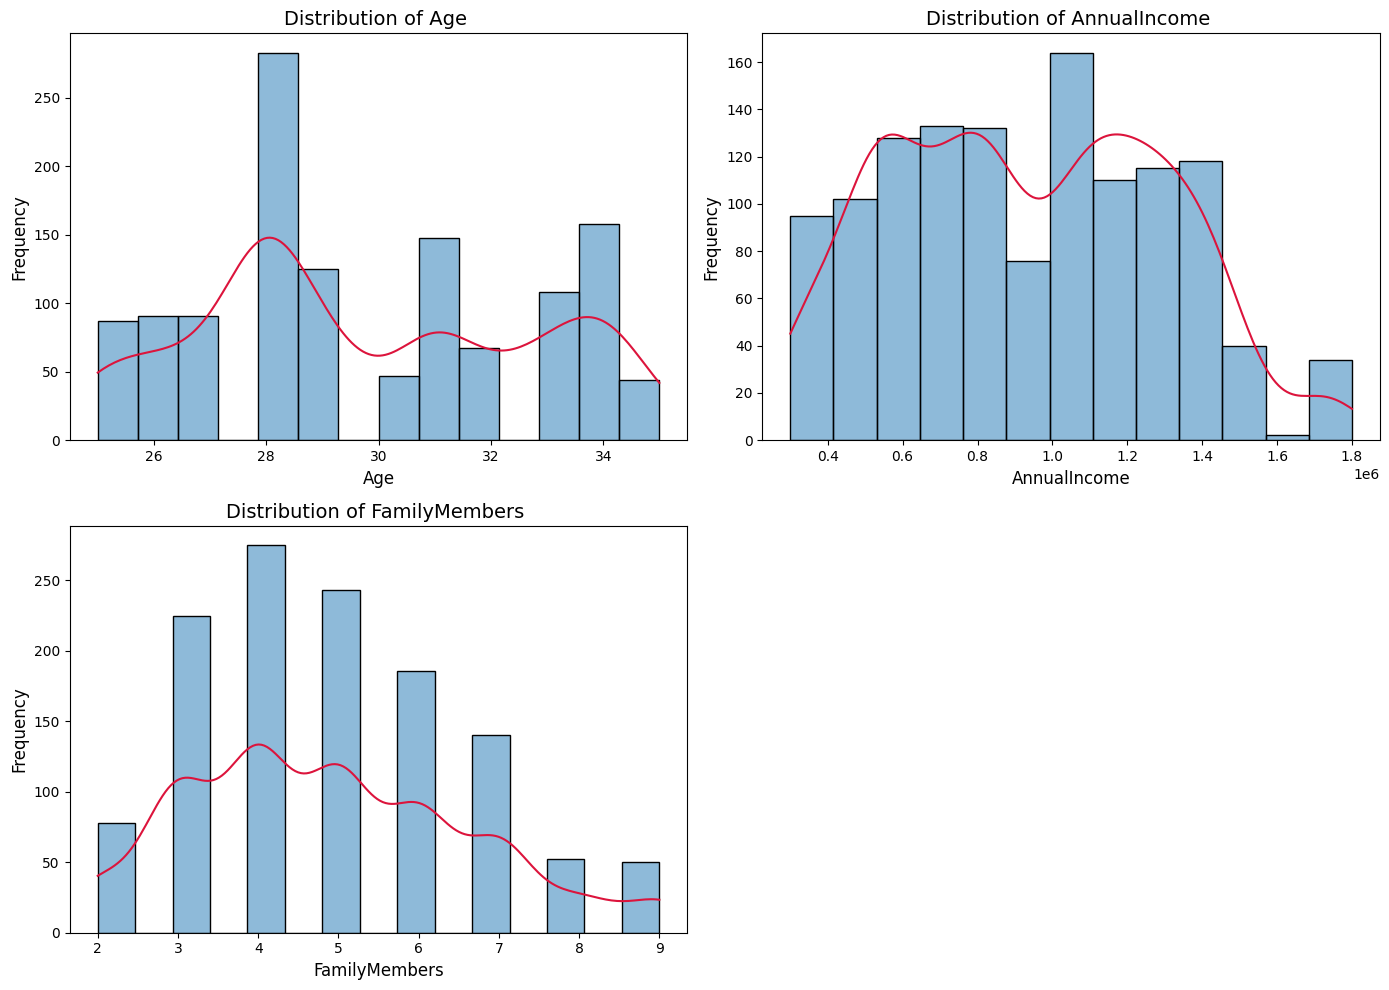

In [13]:
plot_continuos_data(data_continuous)

<h4><b>Summary:</b></h4>
<pre>
* Age ranges from 25 to 35 with a mean of around 29.65. 
* Annual income ranges from 300,000 to 1,800,000 with a mean of approximately 932,763.
* Family Members: Most common family size is between 4 to 6 members.

All of these numerical columns looks phenomenon of normal distribution with some skewness. However it is visually observable that no outliers are there in the data.

<pre><h2>2.2 Categorical Variables</h2>

In [14]:
data_categorical = data[
    [
        "Employment Type",
        "GraduateOrNot",
        "ChronicDiseases",
        "FrequentFlyer",
        "EverTravelledAbroad",
        "TravelInsurance",
    ]
]

In [15]:
@plot_decorator
def categorical_columns_proportions(data, column, ax):
    df = data.groupby(column)[column].agg(value_count="value_counts").reset_index()
    df["proportions"] = (
        df["value_count"].apply(lambda a: round(a / df["value_count"].sum(), 2)) * 100
    )

    # Plotting on the given axis
    sns.barplot(x=column, y="proportions", data=df, ax=ax)
    ax.set_title(f"Proportions of {column}")
    ax.set_xlabel("Category")
    ax.set_ylabel("Proportions")

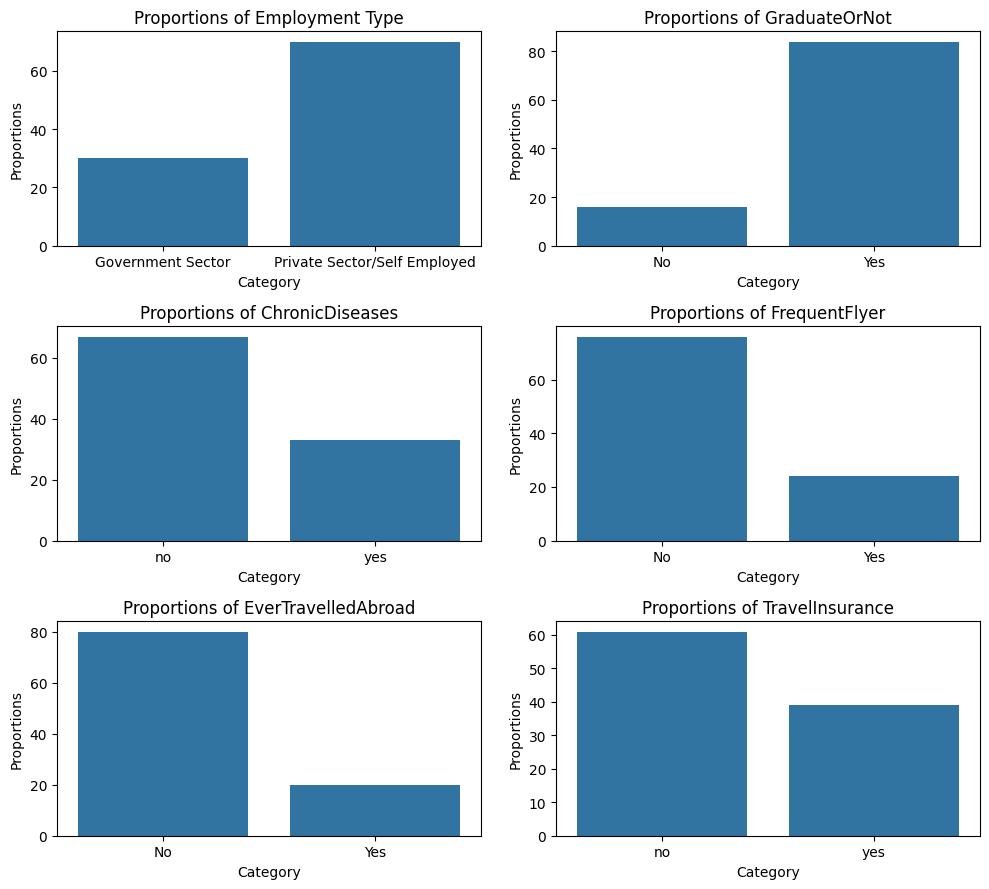

In [16]:
# Create figure and axes
fig, axes = plt.subplots(3, 2, figsize=(10, 3 * 3))
axes = axes.flatten()  # Flatten in case we have fewer axes than needed

# Call the decorated function
categorical_columns_proportions(data_categorical, axes)

<h4><b>Summary:</b></h4>
<pre>* The majority of individuals are in the private sector (71.3%) and are graduates (85.1%).
* Approximate 80% of the individuals haven't travelled abroad. And same goes for Frequent flyers.
* Chronic Diseases: 27.8% of the individuals have chronic diseases.
* About 35.7% have travel insurance and majority (around 64.3%) do not have travel insurance.

<pre><h2>2.3 Bivariate Analysis</h2>

### Proportions

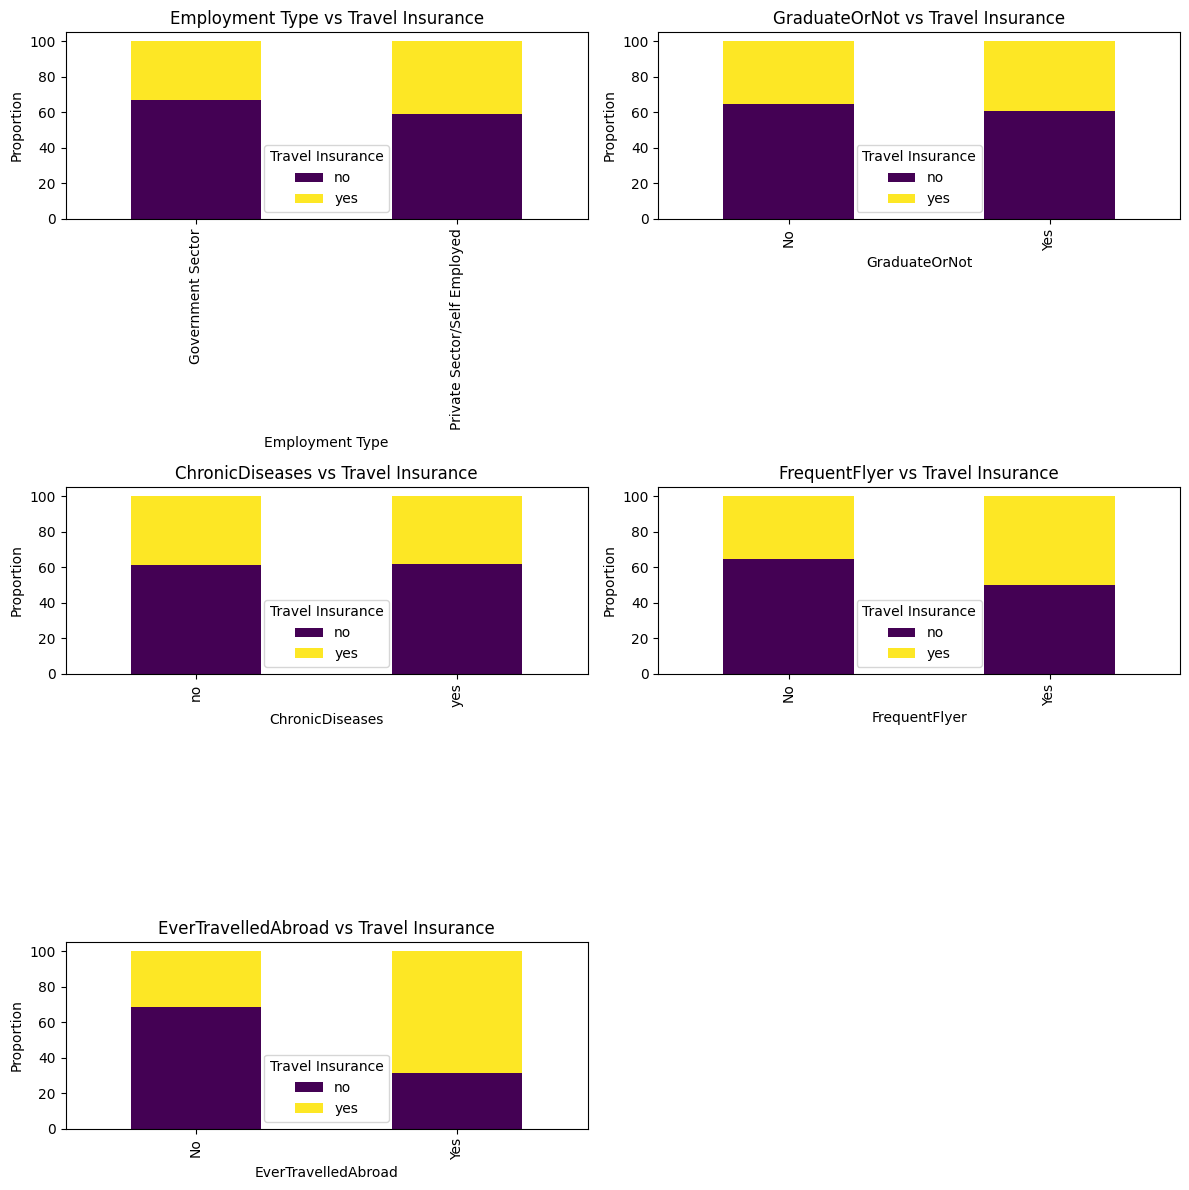

In [17]:
@plot_decorator
def plot_crosstab(data, column, ax, target_col=data["TravelInsurance"]):
    crosstab = pd.crosstab(data[column], target_col, normalize="index") * 100
    crosstab.plot(kind="bar", stacked=True, ax=ax, colormap="viridis")
    ax.set_title(f"{column} vs Travel Insurance")
    ax.set_xlabel(column)
    ax.set_ylabel("Proportion")
    ax.legend(title="Travel Insurance")


fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Adjust size and layout as needed
axes = axes.flatten()

plot_crosstab(
    data[
        [
            "Employment Type",
            "GraduateOrNot",
            "ChronicDiseases",
            "FrequentFlyer",
            "EverTravelledAbroad",
        ]
    ],
    axes,
)

### Boxplots

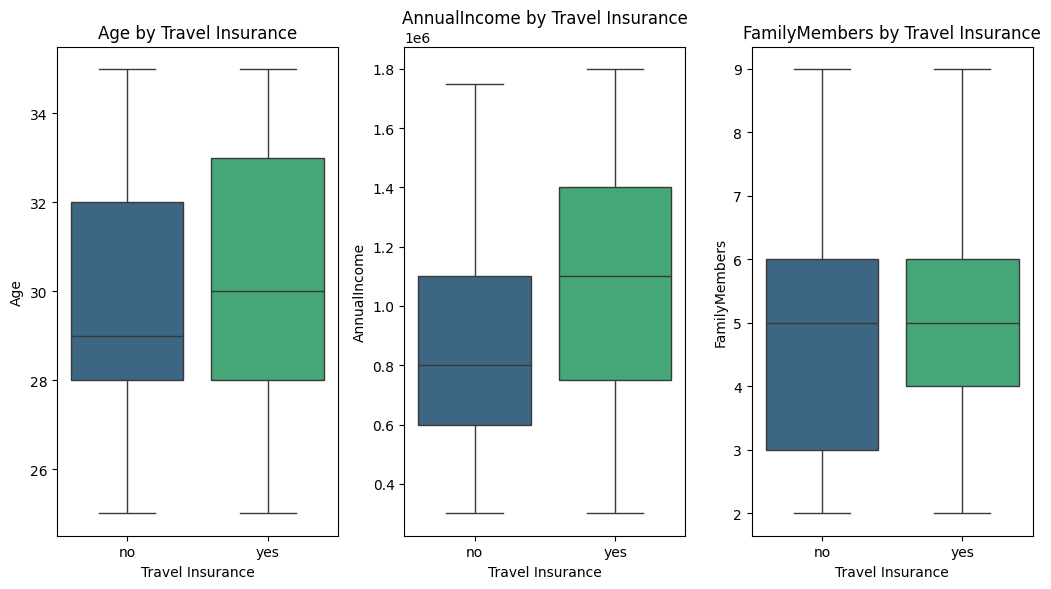

In [18]:
@plot_decorator
def plot_boxplot(df, column, ax, target_col=data["TravelInsurance"]):
    sns.boxplot(x=target_col, y=column, data=df, ax=ax, palette="viridis")
    ax.set_title(f"{column} by Travel Insurance")
    ax.set_xlabel("Travel Insurance")
    ax.set_ylabel(column)


fig, axes = plt.subplots(1, 4, figsize=(14, 6))
axes = axes.flatten()

plot_boxplot(data[["Age", "AnnualIncome", "FamilyMembers"]], axes)

<u><b><h4>Observations</h4></b></u>
<pre><u>1.Employment Type</u>:
        Government Sector: 32.98% opt for travel insurance.
        Private Sector/Self-Employed: Higher uptake, with 41.10% choosing insurance.

<u>2.Graduate Status</u>: Graduates are more likely to purchase travel insurance (39.35%) compared to non-graduates (35.15%).
    
<u>3.Frequent Flyer</u>: Frequent flyers are significantly more likely to have travel insurance (49.83%) compared to non-frequent flyers (35.22%).
    
<u>4.Travel Abroad History</u>: Individuals who have traveled abroad are much more likely to have travel insurance (68.44%) than those who haven’t (31.44%).

5.Individuals who purchased travel insurance tend to be slightly older, though the median age difference is not very large.

6. There is a noticeable difference in annual income. Those with travel insurance generally have higher incomes, suggesting a 
    positive relationship between income level and purchasing travel insurance.

7. The number of family members shows a slight tendency where smaller family sizes are more likely to purchase travel insurance.

<b>The above results are leading to formulate following hypothesis testing.</b>
    Hypothesis 1: Is there a significant difference in the annual income of those who have travel insurance vs those who don't?
    Hypothesis 2: Is there an association between FrequentFlyer status and having travel insurance?
    

<pre><h2>2.4 Multicollinearity  among categorical variables</h2>

<pre>To asses the multicollinearity among predictors Mutual Information (MI) is used.
MI captures both linear and nonlinear dependencies between variables, unlike correlation or VIF, which only detect linear relationships. It works for mixed data types without strict assumptions, unlike hypothesis tests like ANOVA or Chi-Square and Phi-K is a specialized measure for categorical data associations. 
MI is a flexible and comprehensive method for assessing multicollinearity in complex datasets.

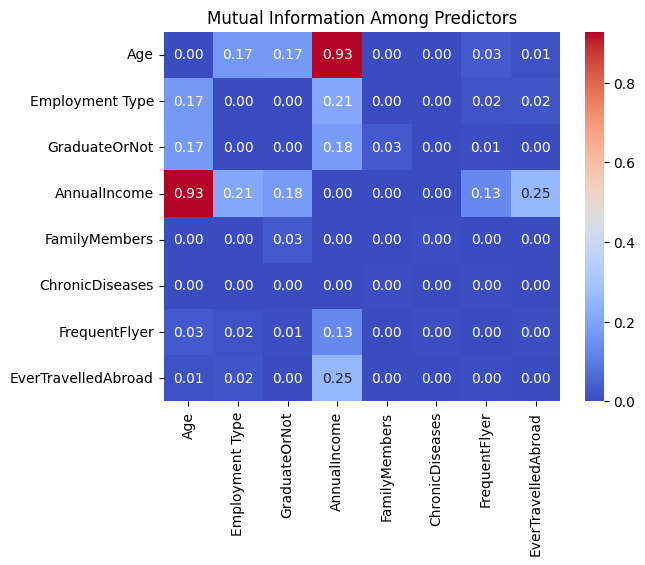

In [22]:
predictors = data.drop(columns=["TravelInsurance"])

label_encoders = {}
for col in predictors.select_dtypes(include="object").columns:
    le = LabelEncoder()
    predictors[col] = le.fit_transform(predictors[col])
    label_encoders[col] = le

mi_matrix = pd.DataFrame(
    np.zeros((len(predictors.columns), len(predictors.columns))),
    index=predictors.columns,
    columns=predictors.columns,
)

for i, col1 in enumerate(predictors.columns):
    for j, col2 in enumerate(predictors.columns):
        if i < j:
            if predictors[col1].nunique() <= 10 and predictors[col2].nunique() <= 10:
                mi = mutual_info_classif(predictors[[col1]], predictors[col2])[0]
            elif predictors[col1].nunique() > 10 and predictors[col2].nunique() > 10:
                mi = mutual_info_classif(predictors[[col1]], predictors[col2])[0]
            else:
                mi = mutual_info_classif(predictors[[col1]], predictors[col2])[0]
            mi_matrix.loc[col1, col2] = mi
            mi_matrix.loc[col2, col1] = mi

sns.heatmap(mi_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Mutual Information Among Predictors")
plt.show()

<u><b><h4>Key Observations:</h4></b></u>
<pre>1. Age and AnnualIncome have a very high MI (0.93), indicating strong multicollinearity. Including both might introduce redundancy.
2. AnnualIncome and EverTravelledAbroad have a moderately high MI (0.25), indicating some dependency but not critical.
3. Based on domain knowledge, keep AnnualIncome if it’s more relevant to predicting travel insurance purchase behavior (likely more indicative of economic capability) and remove Age.
4. Based on the results one may consider to,
    Keep: AnnualIncome, Employment Type, GraduateOrNot, FrequentFlyer, EverTravelledAbroad
    Consider Removing: Age, potentially FamilyMembers or ChronicDiseases.

    However keeping all the predictors might not influence the most of the Machine Learning algorithms to produce results.

<pre><h1>3. Statistical Inferences</h2>

<pre><h2>3.1 Confidence intervals of Proportion</h2>
<pre>From the above proportion results of the Travel Insurance to check the range of values within which the true population proportion is likely to fall, based on a sample estimate. Let us consider 95% confidence level.

In [23]:
n = len(data["TravelInsurance"])
results = []
for category, count in data["TravelInsurance"].value_counts().items():
    proportion = count / n
    ci_low, ci_high = proportion_confint(count, n, alpha=0.05, method="normal")
    results.append(
        {
            "TravelInsurance": category,
            "Proportion": proportion,
            "CI_Low": ci_low,
            "CI_High": ci_high,
        }
    )

travel_insurance_CI = pd.DataFrame(results)
travel_insurance_CI

,TravelInsurance,Proportion,CI_Low,CI_High
0,no,0.613291,0.586283,0.640299
1,yes,0.386709,0.359701,0.413717


<u><h4>Observations:</h4></u>
<pre>
* As we know that dataset is large enough to get the norrowed confidendence intervals. Also the CIs for the two categories are not overlaping, suggesting a statistically significant difference in their proportions.
* There is an imbalance in the classes, but it's not extreme. Class "Yes" is underrepresented compared to "No".
* The imbalance could affect model performance, particularly for models sensitive to majority classes.

<pre><h2>3.2 Hypotheses tests</h2>

<h4><b>Assumptions for hypothesis:</b></h4>
<pre>Hypothesis 1: As the 'AnnualIncome' shows non-normality in the data,we use a non-parametric test like the Mann-Whitney U test (mannwhitneyu), which doesn't require the assumption of normality.

Hypothesis 2: Since both "FrequentFlyer" and "TravelInsurance" are categorical variables, the Chi-Square Test of Independence is being used for testing whether there is a significant association between them.

In [24]:
df = pd.DataFrame(data)

# Hypothesis 1: Is there a significant difference in the annual income of those who have travel insurance vs those who don't?
df["TravelInsurance"] = df["TravelInsurance"].map({"yes": 1, "no": 0})

insurance_yes = df[df["TravelInsurance"] == 1]["AnnualIncome"]
insurance_no = df[df["TravelInsurance"] == 0]["AnnualIncome"]
u_stat, p_value_income = mannwhitneyu(insurance_yes, insurance_no)

# Hypothesis 2: Is there an association between FrequentFlyer status and having travel insurance?
freq_flyer_insurance = pd.crosstab(df["FrequentFlyer"], df["TravelInsurance"])
chi2_stat, p_value_chi2, dof, expected = chi2_contingency(freq_flyer_insurance)

print(f"Hypothesis 1: U-statistic: {u_stat:.2f}, p-value: {p_value_income:.4f}\n")
print(f"Hypothesis 2: chi2_stat:{chi2_stat:.2f}, p-value:{p_value_chi2:.4f}")

Hypothesis 1: U-statistic: 249205.00, p-value: 0.0000

Hypothesis 2: chi2_stat:19.67, p-value:0.0000


<pre><u>Hypothesis 1: Difference in Annual Income</u>

U-statistic: 249205.00
P-value: 0.0000

The p-value is extremely small, indicating a significant difference in annual income between individuals with and without travel insurance.

<u>Hypothesis 2: Association Between Frequent Flyer Status and Travel Insurance</u>

Chi-square statistic: 19.67
P-value: 0.0000

The small p-value suggests a significant association between being a frequent flyer and having travel insurance.
    
Both hypotheses reveal significant relationships, confirming the importance of these factors in predicting travel insurance uptake.

<pre><h1>4. Data Modelling</h2>

<pre><h2>4.1 Data Preprocessing</h2>
<pre>Several steps were already implemented to obtain a cleaned dataset for ML model building. Now, the columns 'Employment Type', 'GraduateOrNot', 'FrequentFlyer', and 'EverTravelledAbroad' contained textual data are encoded since machine learning algorithms require numerical input and output. 
Therefore, these categorical variables must be encoded as integer values before being utilized for model training and testing. Also 
numerical predictors will be scaled using standard scaling.


In [25]:
df = data[
    [
        "Age",
        "Employment Type",
        "GraduateOrNot",
        "AnnualIncome",
        "FamilyMembers",
        "ChronicDiseases",
        "FrequentFlyer",
        "EverTravelledAbroad",
        "TravelInsurance",
    ]
]

binary_columns = [
    "GraduateOrNot",
    "ChronicDiseases",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "TravelInsurance",
]
for col in binary_columns:
    df[col] = df[col].map({"Yes": 1, "No": 0, "yes": 1, "no": 0})

# Encoding Employment Type with One-Hot Encoding, Private Sector/Self Employed:1
df = pd.get_dummies(
    df, columns=["Employment Type"], dtype="int", drop_first=True
).rename(columns={"Employment Type_Private Sector/Self Employed": "Employment Type"})

In [26]:
df.head(2)

,Age,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,Employment Type
0,31,1,400000,6,1,0,0,0,0
1,31,1,1250000,7,0,0,0,0,1


<pre><h2>4.2 Data Spliting</h2>
<pre>The dataset is split into training (70%) and testing (30%) sets, and the features 'AnnualIncome', 'Age', and 'FamilyMembers' are scaled using StandardScaler to standardize their values. The target variable 'TravelInsurance' is separated from the features, and the shapes of the resulting training and testing sets are displayed for model training and evaluation.

In [27]:
data_train, data_test = train_test_split(df, test_size=0.3, random_state=100)

In [28]:
columns_to_transform = ["AnnualIncome", "Age", "FamilyMembers"]

scaler = StandardScaler()

data_train[columns_to_transform] = scaler.fit_transform(
    data_train[columns_to_transform]
)
data_test[columns_to_transform] = scaler.fit_transform(data_test[columns_to_transform])

In [29]:
X_train = data_train.drop(columns=["TravelInsurance"])
y_train = data_train["TravelInsurance"]

X_test = data_test.drop(columns=["TravelInsurance"])
y_test = data_test["TravelInsurance"]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((874, 8), (375, 8), (874,), (375,))

##### <pre><h2>4.3 Fitting the models</h2>
<pre>The function  'build_and_tune_model' function streamlines "hyperparameter tuning", model evaluation, and reporting for any machine learning model. It uses 'GridSearchCV' to find the best hyperparameters based on a scoring metric (default, 'roc_auc') with cross-validation. The best model is then evaluated on the test set, generating metrics like AUC-ROC, precision, recall, and F1-score. This reusable and consistent framework simplifies comparisons across models and reduces repetitive coding.

<pre>Using the following code **hyperparameter grids** for KNN, Decision Tree, Random Forest, and SVM models, specifying the parameter ranges are being tuned. 
A list of models, their grids, and names is iterated through to:  
1. Use the above 'build_and_tune_model' function to perform hyperparameter tuning and evaluation for each model.  
2. Collect performance metrics and the best model for comparison.

In this step all models are trained, tuned and evaluated efficiently. It also enables direct comparisons.

<pre>Let us assign some hyperparameters to find the best combination of those

In [30]:
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"],
}

param_grid_dt = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],
}

<pre>The models are iterated over, and for each, the build_and_tune_model function is used to train, tune, and evaluate them. The best model is stored in best_model_params, and the metrics are appended to results.

In [31]:
models = [
    (KNeighborsClassifier(), param_grid_knn, "KNN"),
    (DecisionTreeClassifier(random_state=42), param_grid_dt, "Decision Tree"),
    (RandomForestClassifier(random_state=42), param_grid_rf, "Random Forest"),
    (SVC(probability=True, random_state=42), param_grid_svm, "SVM"),
]

best_model_params = {}
results = []

for model, param_grid, model_name in models:
    metrics, best_model = build_and_tune_model(
        model, param_grid, model_name, X_train, y_train, X_test, y_test
    )
    best_model_params[model_name] = best_model
    results.append(metrics)
    print("\n", "-" * 50)

Building and Tuning KNN:

Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best Cross-Validated roc_auc: 0.69

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       239
           1       0.69      0.54      0.60       136

    accuracy                           0.74       375
   macro avg       0.73      0.70      0.71       375
weighted avg       0.74      0.74      0.74       375

AUC-ROC for KNN: 0.74

 --------------------------------------------------
Building and Tuning Decision Tree:

Best Parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best Cross-Validated roc_auc: 0.72

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       239
           1       0.85      0.54      0.66       136

    accuracy                           

<pre>creates a DataFrame from the results dictionary and then sorts the rows in descending order based on the "Test AUC-ROC" column, allowing you to view the models in order of their performance.

In [32]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Test AUC-ROC", ascending=False)

,Model,Best Parameters,Cross-Validated AUC,Test AUC-ROC,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1)
1,Decision Tree,"{'max_depth': 3, 'min_samples_leaf': 4, 'min_s...",0.720402,0.745570,0.797333,0.848837,0.536765,0.657658
3,SVM,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.713518,0.741770,0.776000,0.776596,0.536765,0.634783
0,KNN,"{'metric': 'manhattan', 'n_neighbors': 9, 'wei...",0.690380,0.738401,0.744000,0.688679,0.536765,0.603306
2,Random Forest,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.709728,0.736140,0.794667,0.847059,0.529412,0.651584


<pre><h2>4.4 models performance</h2>
<pre>The results_df dictionary is converted into a DataFrame, the "Best Parameters" column is removed, and the data is reshaped into a long format for easier plotting. A bar plot is generated to compare the performance metrics across different models, with each metric on the x-axis and its corresponding value on the y-axis, using different colors for each model. The plot is customized with labels, a title, and a legend for clarity.

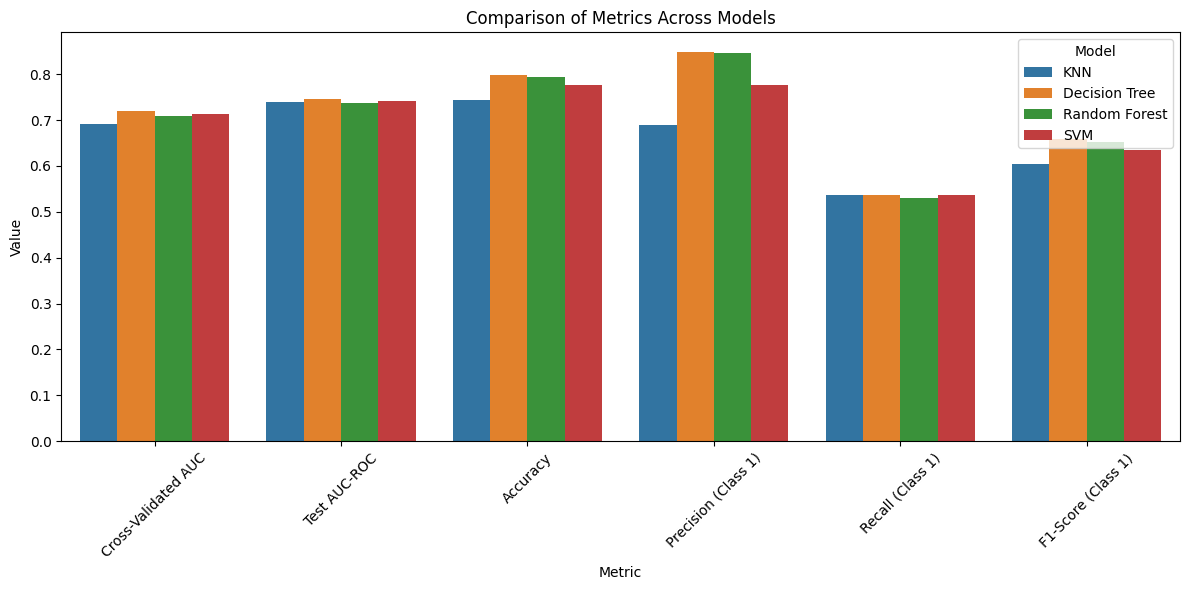

In [33]:
df_results = pd.DataFrame(results_df)

df_results_no_params = df_results.drop(columns="Best Parameters")

df_long = df_results_no_params.melt(
    id_vars="Model", var_name="Metric", value_name="Value"
)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x="Metric", y="Value", hue="Model")
plt.title("Comparison of Metrics Across Models")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

<h4><b>Observations of the Plot:</b></h4>
<pre>While formulating the business objective it was consered our best model should reduce the 'false negative' predictions i.e. recall. However all the models have almost same recall proportions. Then we look at precision and f1 scores specifically. 
Among all tree based models are outperforming especially Decision tree. 

* Recall (Class 1): Decision Tree has the highest recall for detecting the minority class.
* Precision (Class 1): Decision Tree is also the most precise for Class 1.
* F1-Score: Decision Tree strikes a better balance between precision and recall compared to others.
* Test AUC-ROC: Decision Tree outperforms other models slightly.

<pre>We will plot the ROC curves for each model using their predictions on the test set. The AUC-ROC values will help visually compare performance.

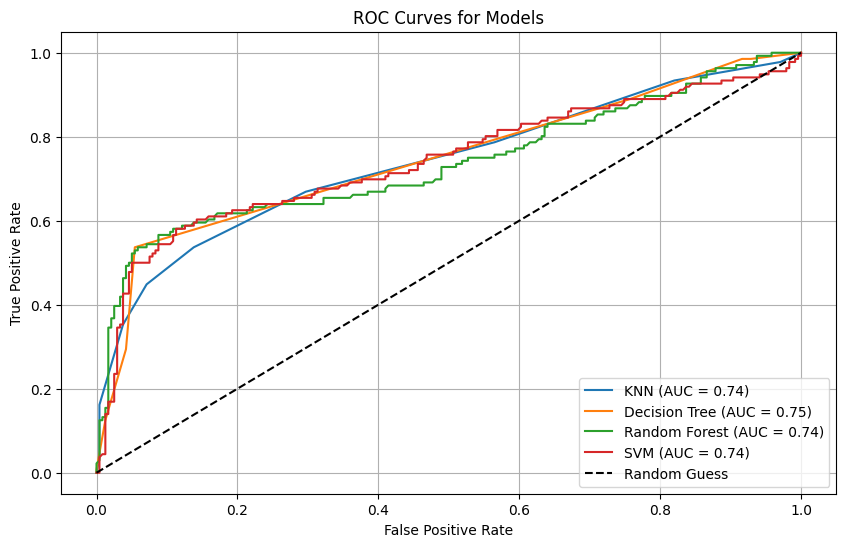

In [34]:
models_predictions = []
for model_name in best_model_params.keys():
    y_prob = best_model_params[model_name].predict_proba(X_test)[:, 1]
    models_predictions.append((model_name, y_prob))

plt.figure(figsize=(10, 6))
for model_name, y_prob in models_predictions:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves for Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

<h4><b>Selecting the Best Model:</b></h4>
<pre>Based on the Test AUC-ROC values:
    * Decision Tree has the highest Test AUC-ROC of 0.75.
    * Decision Tree also has the best recall for Class 1 (0.54), indicating better ability to capture the minority class.

<pre><h1>Conclusions:</h1>
<pre>* Removing duplicates helped avoid data leakage and prevented overestimation of model performance.
    
* Factors such as Employment Type, Graduate Status, Frequent Flyer, and Travel Abroad History were strongly correlated with the likelihood of purchasing travel insurance.
  
* Hypothesis testing revealed a significant difference in Annual Income between insurance buyers and non-buyers, and a strong association between Frequent Flyer status and the likelihood of purchasing travel insurance.
  
* Although there was some class imbalance, it did not severely affect model performance, but this was taken into account during evaluation.

* The Decision Tree model achieved the best performance with the highest accuracy (79.73%), precision (0.8488), and F1-score (0.6577), although its recall could be improved. SVM and Random Forest showed similar performance, while KNN had the lowest accuracy and recall among all models.

<pre><h1>Suggestions for Improvement:</h1>
<pre>Handle Class Imbalance: Consider using undersampling or adjusting class weights to improve recall for Class 1, as it is low across models.

Experiment with More Hyperparameters: Fine-tune the hyperparameters for Random Forest and SVM, such as exploring additional values for C, gamma, and max_depth to improve model performance.

Try Ensemble Models: Combine the predictions from multiple models using techniques like stacking or voting to enhance overall performance.

Feature Engineering: Explore additional feature transformations or interactions between variables to potentially capture more information for improved predictions.